In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/NLP\ Project

Mounted at /content/gdrive
/content/gdrive/MyDrive/NLP Project


In [2]:
! pip install -qq transformers
! pip install -qq transformers-interpret

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 40.0 MB/s 
     |████████████████████████████████| 61 kB 508 kB/s 
     |████████████████████████████████| 596 kB 44.4 MB/s 
     |████████████████████████████████| 3.3 MB 28.1 MB/s 
     |████████████████████████████████| 1.4 MB 8.0 MB/s 


In [3]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertModel, AutoModelForSequenceClassification
from transformers_interpret import SequenceClassificationExplainer
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# Import Data

In [4]:
with open("HateXPlainData/trainHateXplain", "rb") as file:
  train_data = pickle.load(file)

with open("HateXPlainData/valHateXplain", "rb") as file:
  val_data = pickle.load(file)

with open("HateXPlainData/testHateXplain", "rb") as file:
  test_data = pickle.load(file)



# Creating Datasets

In [42]:
BERT_MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 100
BATCH_SIZE = 16

tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL_NAME)
labels = {'offensive': 2, 'hatespeech': 0, 'normal': 1}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70

In [6]:
class DataSet:
  def __init__(self, data, tokenizer, class_labels):
    
    self.text, self.labels = zip(*data)
    self.tokenizer = tokenizer
    self.classes = class_labels
      
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):

    text_encoding = self.tokenizer.encode_plus(" ".join(self.text[idx]), 
                                               add_special_tokens=True,
                                               truncation=True,
                                               max_length=MAX_LEN, 
                                               return_token_type_ids=False, 
                                               padding='max_length', 
                                               return_attention_mask=True, 
                                               return_tensors='pt'
                                              )

    return {'text': " ".join(self.text[idx]),
            'input_ids': text_encoding['input_ids'].flatten(),
            'attention_mask': text_encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.classes[self.labels[idx]])
            }

In [44]:
train = DataSet(train_data, tokenizer, labels)
val = DataSet(val_data, tokenizer, labels)
test = DataSet(test_data, tokenizer, labels)
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE)

# Tweet Classification Model w/ DistilBERT

In [8]:
class TweetClassifier(nn.Module):
  def __init__(self, num_classes):
    super(TweetClassifier, self).__init__()

    self.bert = DistilBertModel.from_pretrained(BERT_MODEL_NAME)
    self.drop_layer = nn.Dropout(p=0.3)
    self.out_layer = nn.Linear(self.bert.config.hidden_size, num_classes)
    self.out_act = nn.Softmax(dim=1)
    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, input, mask):

    bert_output = self.bert(input_ids=input, attention_mask=mask)
    p_out = bert_output[0][:, 0]
    drop_out = self.drop_layer(p_out)
    output = self.out_layer(drop_out)
    return self.out_act(output)

  def fit(self, train_dl, val_dl, epochs, optim):

    train_data = train_dl
    train_size = len(train_data.dataset.text)

    optimizer = optim

    for i in range(epochs):
      self.train()
      train_loss = 0
      train_acc = 0
      print(f'Epochs: {i + 1}')

      for data in tqdm(train_data):
        inputs = data['input_ids'].to(device)
        masks = data['attention_mask'].to(device)
        targets = data['label'].to(device)

        outputs = self.forward(inputs, masks) 

        batch_loss = self.loss_fn(outputs, targets)
        train_loss += batch_loss.item()

        acc = (outputs.argmax(dim=1) == targets).sum().item()
        train_acc += acc

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

      print(f'Train Loss: {train_loss / train_size: .3f} | Train Accuracy: {train_acc / train_size: .3f}')

      self.evaluate(val_dl, calc_loss=True)

  def evaluate(self, eval_dl, calc_loss=False):
    self.eval()

    eval_data = eval_dl
    eval_size = len(eval_data.dataset.text)
    eval_acc = 0
    if calc_loss:
      eval_loss = 0

    predictions = torch.tensor([])

    with torch.no_grad():
      
      for data in tqdm(eval_data):
        inputs = data['input_ids'].to(device)
        masks = data['attention_mask'].to(device)
        targets = data['label'].to(device)

        outputs = self.forward(inputs, masks)

        if calc_loss:
          batch_loss = self.loss_fn(outputs, targets)
          eval_loss += batch_loss.item()

        batch_pred = outputs.argmax(dim=1)
        predictions = torch.cat((predictions, batch_pred.to(device="cpu")), 0)
        acc = (batch_pred == targets).sum().item()
        eval_acc += acc

    if calc_loss:
      print(f'Eval Loss: {eval_loss / eval_size: .3f} | Eval Accuracy: {eval_acc / eval_size: .3f}')
    else:
      print(f'Eval Accuracy: {eval_acc / eval_size: .3f}')

    return predictions


In [13]:
tmodel = TweetClassifier(len(labels)).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
optim = Adam(tmodel.parameters(), lr=5e-5, weight_decay=0.01)

tmodel.fit(train_dataloader, val_dataloader, 5, optim)

Epochs: 1


100%|██████████| 962/962 [04:43<00:00,  3.39it/s]


Train Loss:  0.057 | Train Accuracy:  0.618


100%|██████████| 121/121 [00:14<00:00,  8.52it/s]


Eval Loss:  0.057 | Eval Accuracy:  0.636
Epochs: 2


100%|██████████| 962/962 [04:43<00:00,  3.39it/s]


Train Loss:  0.056 | Train Accuracy:  0.653


100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


Eval Loss:  0.057 | Eval Accuracy:  0.620
Epochs: 3


100%|██████████| 962/962 [04:43<00:00,  3.39it/s]


Train Loss:  0.055 | Train Accuracy:  0.669


100%|██████████| 121/121 [00:14<00:00,  8.53it/s]


Eval Loss:  0.056 | Eval Accuracy:  0.641
Epochs: 4


100%|██████████| 962/962 [04:43<00:00,  3.39it/s]


Train Loss:  0.054 | Train Accuracy:  0.689


100%|██████████| 121/121 [00:14<00:00,  8.53it/s]


Eval Loss:  0.056 | Eval Accuracy:  0.651
Epochs: 5


100%|██████████| 962/962 [04:43<00:00,  3.39it/s]


Train Loss:  0.052 | Train Accuracy:  0.718


100%|██████████| 121/121 [00:14<00:00,  8.51it/s]

Eval Loss:  0.057 | Eval Accuracy:  0.635


In [28]:
torch.save(tmodel.state_dict(), './DistilBERTModel/model')

# Evaluating the Model

In [45]:
y_train_true = np.array([labels[label] for label in train.labels])
y_val_true = np.array([labels[label] for label in val.labels])
y_test_true = np.array([labels[label] for label in test.labels])
#y_train_pred = tmodel.evaluate(train_dataloader)
#y_val_pred = tmodel.evaluate(val_dataloader)
#y_test_pred = tmodel.evaluate(test_dataloader)

Train Data Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      6251
           1       0.80      0.85      0.82      4748
           2       0.64      0.67      0.66      4384

    accuracy                           0.76     15383
   macro avg       0.75      0.75      0.75     15383
weighted avg       0.76      0.76      0.76     15383



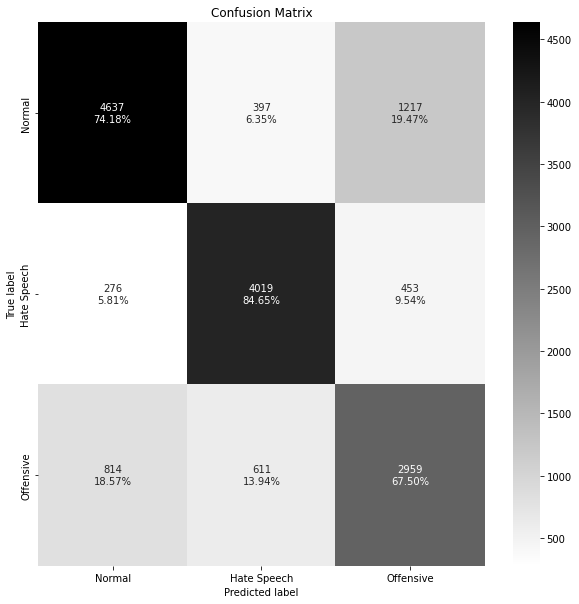

In [16]:
print("Train Data Accuracy: {0:0.2f}".format(accuracy_score(y_train_true, y_train_pred)))
    
print(classification_report(y_train_true, y_train_pred))
cf_matrix = confusion_matrix(y_train_true, y_train_pred)

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Validation Data Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.71      0.61      0.66       781
           1       0.72      0.74      0.73       593
           2       0.47      0.55      0.51       548

    accuracy                           0.63      1922
   macro avg       0.63      0.64      0.63      1922
weighted avg       0.65      0.63      0.64      1922



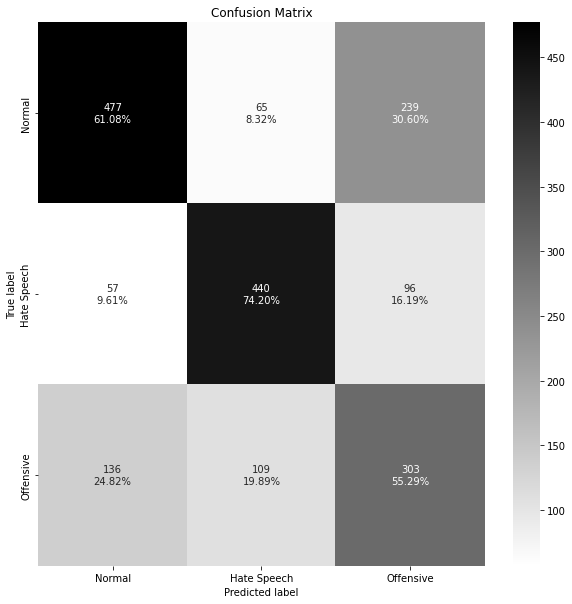

In [17]:
print("Validation Data Accuracy: {0:0.2f}".format(accuracy_score(y_val_true, y_val_pred)))
    
print(classification_report(y_val_true, y_val_pred))
cf_matrix = confusion_matrix(y_val_true, y_val_pred)

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Test Data Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       782
           1       0.70      0.76      0.73       594
           2       0.48      0.54      0.51       548

    accuracy                           0.64      1924
   macro avg       0.63      0.64      0.63      1924
weighted avg       0.65      0.64      0.64      1924



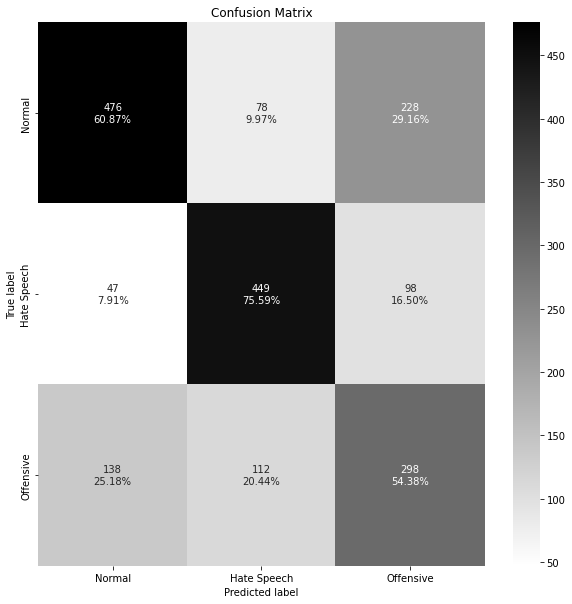

In [18]:
print("Test Data Accuracy: {0:0.2f}".format(accuracy_score(y_test_true, y_test_pred)))
    
print(classification_report(y_test_true, y_test_pred))
cf_matrix = confusion_matrix(y_test_true, y_test_pred)

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Using HuggingFace

In [35]:
! pip install -qq datasets

     |████████████████████████████████| 306 kB 5.3 MB/s 
     |████████████████████████████████| 243 kB 45.3 MB/s 
     |████████████████████████████████| 132 kB 48.1 MB/s 
     |████████████████████████████████| 1.1 MB 46.6 MB/s 
     |████████████████████████████████| 192 kB 47.7 MB/s 
     |████████████████████████████████| 271 kB 49.3 MB/s 
     |████████████████████████████████| 160 kB 48.5 MB/s 


In [37]:
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification, 
                          Trainer, 
                          TrainingArguments)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
import torch

dataset = load_dataset("hatexplain")
train_ds = dataset['train']
test_ds = dataset['test']
val_ds = dataset['validation']

label_extractor = lambda x: max(set(x['label']), key = x['label'].count)
train = {}
train['tokens'] = [' '.join(s) for s in train_ds['post_tokens']]
train['label'] = list(map(label_extractor, train_ds['annotators']))
train_ds = Dataset.from_dict(train)
val = {}
val['tokens'] = [' '.join(s) for s in val_ds['post_tokens']]
val['label'] = list(map(label_extractor, val_ds['annotators']))
val_ds = Dataset.from_dict(val)
test = {}
test['tokens'] = [' '.join(s) for s in test_ds['post_tokens']]
test['label'] = list(map(label_extractor, test_ds['annotators']))
test_ds = Dataset.from_dict(test)


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenize_func = lambda sentences: tokenizer(sentences['tokens'], \
                                            padding="max_length", \
                                            truncation=True)

tok_train_ds = train_ds.map(tokenize_func, batched=True)
tok_test_ds = test_ds.map(tokenize_func, batched=True)
tok_val_ds = val_ds.map(tokenize_func, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
training_args = TrainingArguments(
    output_dir='./',          
    num_train_epochs=8,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./',            
    logging_steps=100,
    save_steps=1000
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Reusing dataset hatexplain (/root/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

In [38]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=tok_train_ds,
    eval_dataset=tok_val_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.evaluate()

***** Running training *****
  Num examples = 15383
  Num Epochs = 8
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7696


Step,Training Loss
100,1.075600
200,0.930700
300,0.824400
400,0.798200
500,0.810800
600,0.777300
700,0.767000
800,0.767200
900,0.742400
1000,0.683600


Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config.json
Model weights saved in ./checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-2000
Configuration saved in ./checkpoint-2000/config.json
Model weights saved in ./checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-3000
Configuration saved in ./checkpoint-3000/config.json
Model weights saved in ./checkpoint-3000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-4000
Configuration saved in ./checkpoint-4000/config.json
Model weights saved in ./checkpoint-4000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-5000
Configuration saved in ./checkpoint-5000/config.json
Model weights saved in ./checkpoint-5000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-6000
Configuration saved in ./checkpoint-6000/config.json
Model weights saved in ./checkpoint-6000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-7000
Configuration

{'epoch': 8.0,
 'eval_accuracy': 0.668054110301769,
 'eval_f1': 0.6635899507933026,
 'eval_loss': 2.3758773803710938,
 'eval_precision': 0.6656763726236274,
 'eval_recall': 0.6634475977254315,
 'eval_runtime': 67.2839,
 'eval_samples_per_second': 28.566,
 'eval_steps_per_second': 1.798}

In [39]:
train_output = trainer.predict(test_dataset=tok_train_ds)
val_output = trainer.predict(test_dataset=tok_val_ds)
test_output = trainer.predict(test_dataset=tok_test_ds)
print(test_output.metrics)

***** Running Prediction *****
  Num examples = 15383
  Batch size = 16


***** Running Prediction *****
  Num examples = 1922
  Batch size = 16
***** Running Prediction *****
  Num examples = 1924
  Batch size = 16


{'test_loss': 2.3552353382110596, 'test_accuracy': 0.6606029106029107, 'test_f1': 0.6545699044677117, 'test_precision': 0.6572984120161425, 'test_recall': 0.6546116596442979, 'test_runtime': 67.317, 'test_samples_per_second': 28.581, 'test_steps_per_second': 1.797}


Train Data Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4748
           1       1.00      1.00      1.00      6251
           2       1.00      1.00      1.00      4384

    accuracy                           1.00     15383
   macro avg       1.00      1.00      1.00     15383
weighted avg       1.00      1.00      1.00     15383



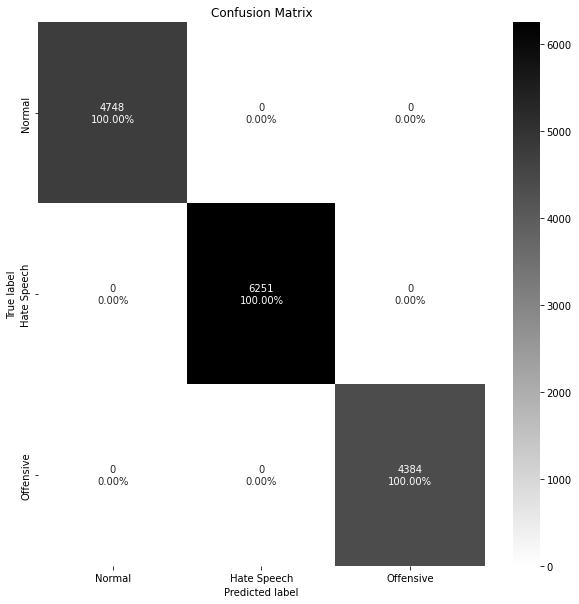

In [46]:
print("Train Data Accuracy: {0:0.2f}".format(accuracy_score(y_train_true, train_output.label_ids)))
    
print(classification_report(y_train_true, train_output.label_ids))
cf_matrix = confusion_matrix(y_train_true, train_output.label_ids)

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Validation Data Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       593
           1       1.00      1.00      1.00       781
           2       1.00      1.00      1.00       548

    accuracy                           1.00      1922
   macro avg       1.00      1.00      1.00      1922
weighted avg       1.00      1.00      1.00      1922



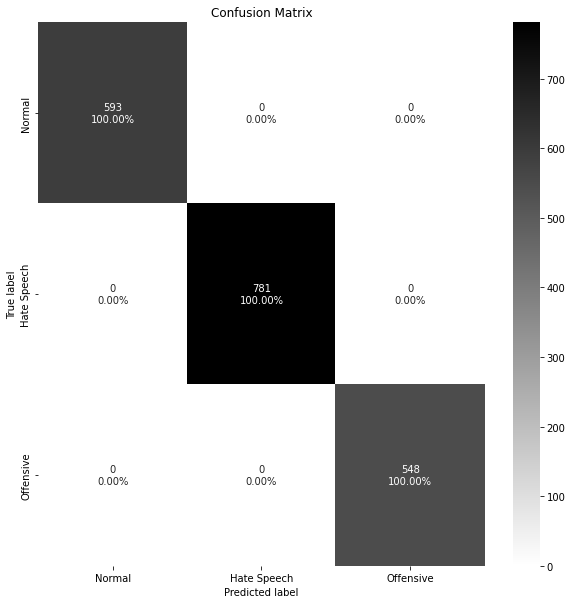

In [47]:
print("Validation Data Accuracy: {0:0.2f}".format(accuracy_score(y_val_true, val_output.label_ids)))
    
print(classification_report(y_val_true, val_output.label_ids))
cf_matrix = confusion_matrix(y_val_true, val_output.label_ids)

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Test Data Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       594
           1       1.00      1.00      1.00       782
           2       1.00      1.00      1.00       548

    accuracy                           1.00      1924
   macro avg       1.00      1.00      1.00      1924
weighted avg       1.00      1.00      1.00      1924



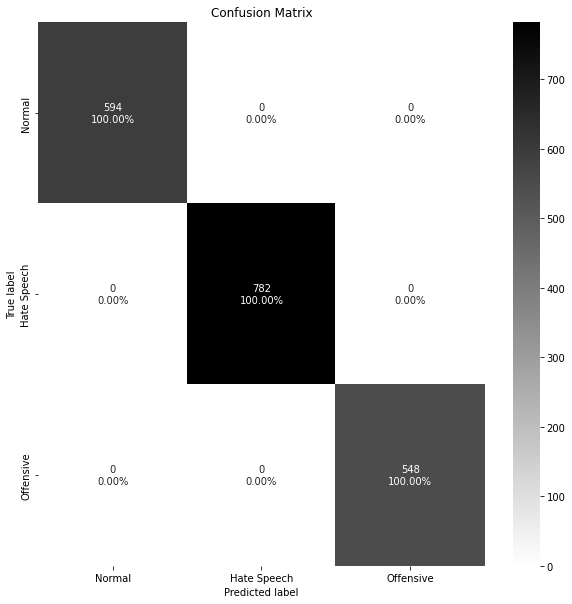

In [48]:
print("Test Data Accuracy: {0:0.2f}".format(accuracy_score(y_test_true, test_output.label_ids)))
    
print(classification_report(y_test_true, test_output.label_ids))
cf_matrix = confusion_matrix(y_test_true, test_output.label_ids)

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Extract labels of the first 20 examples of the test set

In [50]:
labelToStr = {0: 'Hate Speech', 1: 'Normal', 2: 'Offensive'}

model = AutoModelForSequenceClassification.from_pretrained("./checkpoint-7000", num_labels=3)

trainer = Trainer(model=model)

small_test_ds = torch.utils.data.Subset(tok_test_ds, range(20))

small_test_output = trainer.predict(test_dataset=small_test_ds)

cls_explainer = SequenceClassificationExplainer(model, tokenizer)

loading configuration file ./checkpoint-7000/config.json
Model config DistilBertConfig {
  "_name_or_path": "./checkpoint-7000",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "vocab_size": 30522
}

loading weights file ./checkpoint-7000/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification

Sentence: <user> men can not be raped can not be abused that why they call it violence against women and children because men are always the perpetrators women come first even before children
BERT label is Normal
Because of [('[CLS]', 0.0), ('<', -0.13934954886737003), ('user', -0.273677031315234), ('>', 0.18661293331612708), ('men', -0.10313260399849088), ('can', -0.17118088408340448), ('not', 0.058531808459344935), ('be', 0.14296658045755928), ('raped', -0.04185560690820708), ('can', -0.058406312968106895), ('not', -0.07189683721822353), ('be', 0.012424391140939036), ('abused', 0.050984024378601576), ('that', 0.013464061449024583), ('why', 0.058862489149669905), ('they', -0.22757753306559192), ('call', 0.1294716837835557), ('it', 0.07034624566292652), ('violence', 0.04083907268820552), ('against', 0.04149106163828514), ('women', -0.09320125624124916), ('and', -0.10474269536471544), ('children', -0.16357092822288938), ('because', -0.021809716814304256), ('men', -0.2512475605480957), (

In [52]:
for i in range(20):
  print(f"Sentence: {small_test_ds[i]['tokens']}")
  print(f"BERT label is {labelToStr[small_test_output.label_ids[i]]}")
  print(f"Because of {cls_explainer(small_test_ds[i]['tokens'])}")

Sentence: <user> men can not be raped can not be abused that why they call it violence against women and children because men are always the perpetrators women come first even before children
BERT label is Normal
Because of [('[CLS]', 0.0), ('<', -0.13934954886737003), ('user', -0.273677031315234), ('>', 0.18661293331612708), ('men', -0.10313260399849088), ('can', -0.17118088408340448), ('not', 0.058531808459344935), ('be', 0.14296658045755928), ('raped', -0.04185560690820708), ('can', -0.058406312968106895), ('not', -0.07189683721822353), ('be', 0.012424391140939036), ('abused', 0.050984024378601576), ('that', 0.013464061449024583), ('why', 0.058862489149669905), ('they', -0.22757753306559192), ('call', 0.1294716837835557), ('it', 0.07034624566292652), ('violence', 0.04083907268820552), ('against', 0.04149106163828514), ('women', -0.09320125624124916), ('and', -0.10474269536471544), ('children', -0.16357092822288938), ('because', -0.021809716814304256), ('men', -0.2512475605480957), (